# ADA - Project Milestone P2
The jupyter notebook presenting our initial results.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# general helpers
def ratio_to_percentage(ratio):
    """
    
    :param ratio: a number between 0 and 1
    :return: the corresponding percentage with two decimal places
    """
    return round(ratio * 100, 2)

In [3]:
df_ba_users = pd.read_csv("data/BeerAdvocate/users.csv")
df_rb_users = pd.read_csv("data/RateBeer/users.csv")

exp_threshold = 15

df_ba_experienced_users = df_ba_users[df_ba_users["nbr_ratings"] > exp_threshold]
df_rb_experienced_users = df_rb_users[df_rb_users["nbr_ratings"] > exp_threshold]

In [4]:
num_users_ba = len(df_ba_users)
num_exp_users_ba = len(df_ba_experienced_users)
num_users_rb = len(df_rb_users)
num_exp_users_rb = len(df_rb_experienced_users)

perc_ba = 100 - ratio_to_percentage(num_exp_users_ba / num_users_ba)
print("By filtering the datasets, we lost " + str(perc_ba) + "% (" + str(num_users_ba - num_exp_users_ba) + "/" + str(num_users_ba) + ")" + " of the beer advocate dataset")

perc_rb = 100 - ratio_to_percentage(num_exp_users_rb / num_users_rb)
print("By filtering the datasets, we lost " + str(perc_rb) + "% (" + str(num_users_rb - num_exp_users_rb) + "/" + str(num_users_rb) + ")" + " of the rate beer dataset")

perc_both = round((num_users_ba / (num_users_ba + num_users_rb)) * perc_ba + (num_users_rb  / (num_users_rb + num_users_ba)) * perc_rb, 2)
print("Taking both datasets in account we lost " + str(perc_both) + "% (" + str(num_users_ba + num_users_rb - num_exp_users_ba - num_exp_users_rb) + "/" + str(num_exp_users_ba + num_users_rb) + ")" + " of the users")

By filtering the datasets, we lost 74.84% (115025/153704) of the beer advocate dataset
By filtering the datasets, we lost 80.22% (56295/70174) of the rate beer dataset
Taking both datasets in account we lost 76.53% (171320/108853) of the users


# Does the reviewer's rating change over time

In [5]:
# 

# Does the reviewer's rating change for the 10 most popular beers based on the number of reviews given


In [6]:
#Data of interest for this part:
#For the ratings per beer
df_matched_ratings_beers = pd.read_csv(r'data\matched_beer_data\ratings.csv', low_memory=False)
#For the number of given ratings per reviewer
users = pd.read_csv(r'data\matched_beer_data\users.csv')

In [7]:
#Filtering of df_matched_ratings_beers (1), users (2) and merging the 2 df.

#1) The following code creates a new datasets that includes ratings, user_id and beer_name. The dataset is filtered from nan values and its 'object(1)' type od ratings are converted to numerical values.
filtered_df_ratings_beers = df_matched_ratings_beers.dropna()

filtered_overall_beers_ratings_df = pd.DataFrame ({
    'user_id': filtered_df_ratings_beers['ba.15'],
    'ratings': filtered_df_ratings_beers['ba.8'],
    'beer_id': filtered_df_ratings_beers['ba.4']
})

Overall_userid_beers_ratings_df= filtered_overall_beers_ratings_df.drop(0) #Removing first string row which holds no values

Overall_userid_beers_ratings_df['ratings'] = pd.to_numeric(Overall_userid_beers_ratings_df['ratings'], errors='coerce')
print(Overall_userid_beers_ratings_df['ratings'].info())

#2) Filtering of the users dataset and merging with the Overall_userid_beers_ratings_df via users_id

#Creating a separate df containing only the wanted columns of ba.2 (nbr_ratings), ba.4 (user_id)
users_df = pd.DataFrame ({
    'nb_ratings': users['ba.2'],
    'user_id': users['ba.4']
})
users_df= users_df.drop(0) #Removing first string row which holds no values

#With this new dataframe created, now the aim is to merge it with the Trappistes_Rochefort_10_ratings df using the 'user_id' column
ratings_reviews_merged = pd.merge(users_df, Overall_userid_beers_ratings_df, on='user_id')

#Not all values seemed to be numerical, a convertion, using 'pd.to_numeric' is necessary. 
ratings_reviews_merged['nb_ratings'] = pd.to_numeric(ratings_reviews_merged['nb_ratings'], errors='coerce')
#'.info' shows that the nb_ratings column now contains inter64.

<class 'pandas.core.series.Series'>
Index: 17938 entries, 1 to 21964
Series name: ratings
Non-Null Count  Dtype  
--------------  -----  
17938 non-null  float64
dtypes: float64(1)
memory usage: 280.3 KB
None


In [8]:
#In the following code, the objective is to work on the 10 most popular beer types and see if a difference of ratings between experienced (defined as a certain amount of given ratings) and new reviewers can be seen per type of beer. This also aims to see which type of reviewer (new/experienced) dominates the ratings for a small sample of beers. the most reviewed beers were selected (defined as the most popular from the BeerAdvocate dataset) to have enough data for the analysis. 

#The following paragraph code is only the selection of the 10 most popular beer types (based on number of received reviews) (THIS SHOULD BE OPTIMIZABLE LATER ON)
Trappistes_Rochefort_10_ratings = ratings_reviews_merged.loc[ratings_reviews_merged["beer_id"] == "Trappistes Rochefort 10"]
Brooklyn_Black_Chocolate_ratings = ratings_reviews_merged.loc[ratings_reviews_merged["beer_id"] == "Brooklyn Black Chocolate Stout"]
AleSmith_Speedway_ratings = ratings_reviews_merged.loc[ratings_reviews_merged["beer_id"] == "AleSmith Speedway Stout"]
Delirium_Tremens_ratings = ratings_reviews_merged.loc[ratings_reviews_merged["beer_id"] == "Delirium Tremens"]
Titan_IPA_ratings = ratings_reviews_merged.loc[ratings_reviews_merged["beer_id"] == "Titan IPA"]
Blind_Pig_IPA_ratings = ratings_reviews_merged.loc[ratings_reviews_merged["beer_id"] == "Blind Pig IPA"]
Spaten_Optimator_ratings = ratings_reviews_merged.loc[ratings_reviews_merged["beer_id"] == "Spaten Optimator"]
St_Bernardus_Prior_8_ratings = ratings_reviews_merged.loc[ratings_reviews_merged["beer_id"] == "St. Bernardus Prior 8"]
Weihenstephaner_ratings = ratings_reviews_merged.loc[ratings_reviews_merged["beer_id"] == "Weihenstephaner Korbinian"]
Consecration_ratings = ratings_reviews_merged.loc[ratings_reviews_merged["beer_id"] == "Consecration"]

In [9]:
#Classifying users by experience (chosen : experience_threshold) using the number of ratings for each beer type (the 10 most popular). experience_threshold >= is considered an experienced reviewer.
experience_threshold = 15 #Can be changed. Defines experience

Experienced_Trappistes_ratings = Trappistes_Rochefort_10_ratings[Trappistes_Rochefort_10_ratings["nb_ratings"] >= experience_threshold]
New_Trappistes_ratings = Trappistes_Rochefort_10_ratings[Trappistes_Rochefort_10_ratings["nb_ratings"] < experience_threshold]
print('Experienced Trappistes shape')
print(Experienced_Trappistes_ratings.shape)
print('New Trappistes shape')
print(New_Trappistes_ratings.shape)

Experienced_Brooklyn_Black_ratings= Brooklyn_Black_Chocolate_ratings[Brooklyn_Black_Chocolate_ratings["nb_ratings"] >= experience_threshold]
New_Brooklyn_Black_ratings = Brooklyn_Black_Chocolate_ratings[Brooklyn_Black_Chocolate_ratings["nb_ratings"] < experience_threshold]
print('Experienced Brooklyn_Black_Chocolate_Stout_ratings shape')
print(Experienced_Brooklyn_Black_ratings.shape)
print('New Brooklyn_Black_Chocolate_Stout_ratings shape')
print(New_Brooklyn_Black_ratings.shape)

Experienced_AleSmith_Speedway_ratings= AleSmith_Speedway_ratings[AleSmith_Speedway_ratings["nb_ratings"] >= experience_threshold]
New_AleSmith_Speedway_ratings = AleSmith_Speedway_ratings[AleSmith_Speedway_ratings["nb_ratings"] < experience_threshold]
print('Experienced AleSmith_Speedway_Stout_ratings shape')
print(Experienced_AleSmith_Speedway_ratings.shape)
print('New AleSmith_Speedway_Stout_ratings shape')
print(New_AleSmith_Speedway_ratings.shape)

Experienced_Delirium_Tremens_ratings= Delirium_Tremens_ratings[Delirium_Tremens_ratings["nb_ratings"] >= experience_threshold]
New_Delirium_Tremens_ratings = Delirium_Tremens_ratings[Delirium_Tremens_ratings["nb_ratings"] < experience_threshold]
print('Experienced Delirium_Tremens_ratings shape')
print(Experienced_Delirium_Tremens_ratings.shape)
print('New Delirium_Tremens_ratings shape')
print(New_Delirium_Tremens_ratings.shape)

Experienced_Titan_IPA_ratings= Titan_IPA_ratings[Titan_IPA_ratings["nb_ratings"] >= experience_threshold]
New_Titan_IPA_ratings = Titan_IPA_ratings[Titan_IPA_ratings["nb_ratings"] < experience_threshold]
print('Experienced Titan_IPA_ratings shape')
print(Experienced_Titan_IPA_ratings.shape)
print('New Titan_IPA_ratings shape')
print(New_Titan_IPA_ratings.shape)

Experienced_Blind_Pig_IPA_ratings= Blind_Pig_IPA_ratings[Blind_Pig_IPA_ratings["nb_ratings"] >= experience_threshold]
New_Blind_Pig_IPA_ratings = Blind_Pig_IPA_ratings[Blind_Pig_IPA_ratings["nb_ratings"] < experience_threshold]
print('Experienced Blind_Pig_IPA_ratings shape')
print(Experienced_Blind_Pig_IPA_ratings.shape)
print('New Blind_Pig_IPA_ratings shape')
print(New_Blind_Pig_IPA_ratings.shape)

Experienced_Spaten_Optimator_ratings= Spaten_Optimator_ratings[Spaten_Optimator_ratings["nb_ratings"] >= experience_threshold]
New_Spaten_Optimator_ratings = Spaten_Optimator_ratings[Spaten_Optimator_ratings["nb_ratings"] < experience_threshold]
print('Experienced Spaten_Optimator_ratings shape')
print(Experienced_Spaten_Optimator_ratings.shape)
print('New Spaten_Optimator_ratings shape')
print(New_Spaten_Optimator_ratings.shape)

Experienced_St_Bernardus_Prior_8_ratings= St_Bernardus_Prior_8_ratings[St_Bernardus_Prior_8_ratings["nb_ratings"] >= experience_threshold]
New_St_Bernardus_Prior_8_ratings = St_Bernardus_Prior_8_ratings[St_Bernardus_Prior_8_ratings["nb_ratings"] < experience_threshold]
print('Experienced St_Bernardus_Prior_8_ratings shape')
print(Experienced_St_Bernardus_Prior_8_ratings.shape)
print('New St_Bernardus_Prior_8_ratings shape')
print(New_St_Bernardus_Prior_8_ratings.shape)

Experienced_Weihenstephaner_ratings= Weihenstephaner_ratings[Weihenstephaner_ratings["nb_ratings"] >= experience_threshold]
New_Weihenstephaner_ratings = Weihenstephaner_ratings[Weihenstephaner_ratings["nb_ratings"] < experience_threshold]
print('Experienced Weihenstephaner_Korbinian_ratings shape')
print(Experienced_Weihenstephaner_ratings.shape)
print('New Weihenstephaner_Korbinian_ratings shape')
print(New_Weihenstephaner_ratings.shape)

Experienced_Consecration_ratings= Consecration_ratings[Consecration_ratings["nb_ratings"] >= experience_threshold]
New_Consecration_ratings = Consecration_ratings[Consecration_ratings["nb_ratings"] < experience_threshold]
print('Experienced Consecration_ratings shape')
print(Experienced_Consecration_ratings.shape)
print('New Consecration_ratings shape')
print(New_Consecration_ratings.shape)

Experienced Trappistes shape
(142, 4)
New Trappistes shape
(7, 4)
Experienced Brooklyn_Black_Chocolate_Stout_ratings shape
(115, 4)
New Brooklyn_Black_Chocolate_Stout_ratings shape
(0, 4)
Experienced AleSmith_Speedway_Stout_ratings shape
(110, 4)
New AleSmith_Speedway_Stout_ratings shape
(2, 4)
Experienced Delirium_Tremens_ratings shape
(70, 4)
New Delirium_Tremens_ratings shape
(0, 4)
Experienced Titan_IPA_ratings shape
(69, 4)
New Titan_IPA_ratings shape
(0, 4)
Experienced Blind_Pig_IPA_ratings shape
(64, 4)
New Blind_Pig_IPA_ratings shape
(3, 4)
Experienced Spaten_Optimator_ratings shape
(62, 4)
New Spaten_Optimator_ratings shape
(0, 4)
Experienced St_Bernardus_Prior_8_ratings shape
(62, 4)
New St_Bernardus_Prior_8_ratings shape
(0, 4)
Experienced Weihenstephaner_Korbinian_ratings shape
(59, 4)
New Weihenstephaner_Korbinian_ratings shape
(0, 4)
Experienced Consecration_ratings shape
(55, 4)
New Consecration_ratings shape
(4, 4)


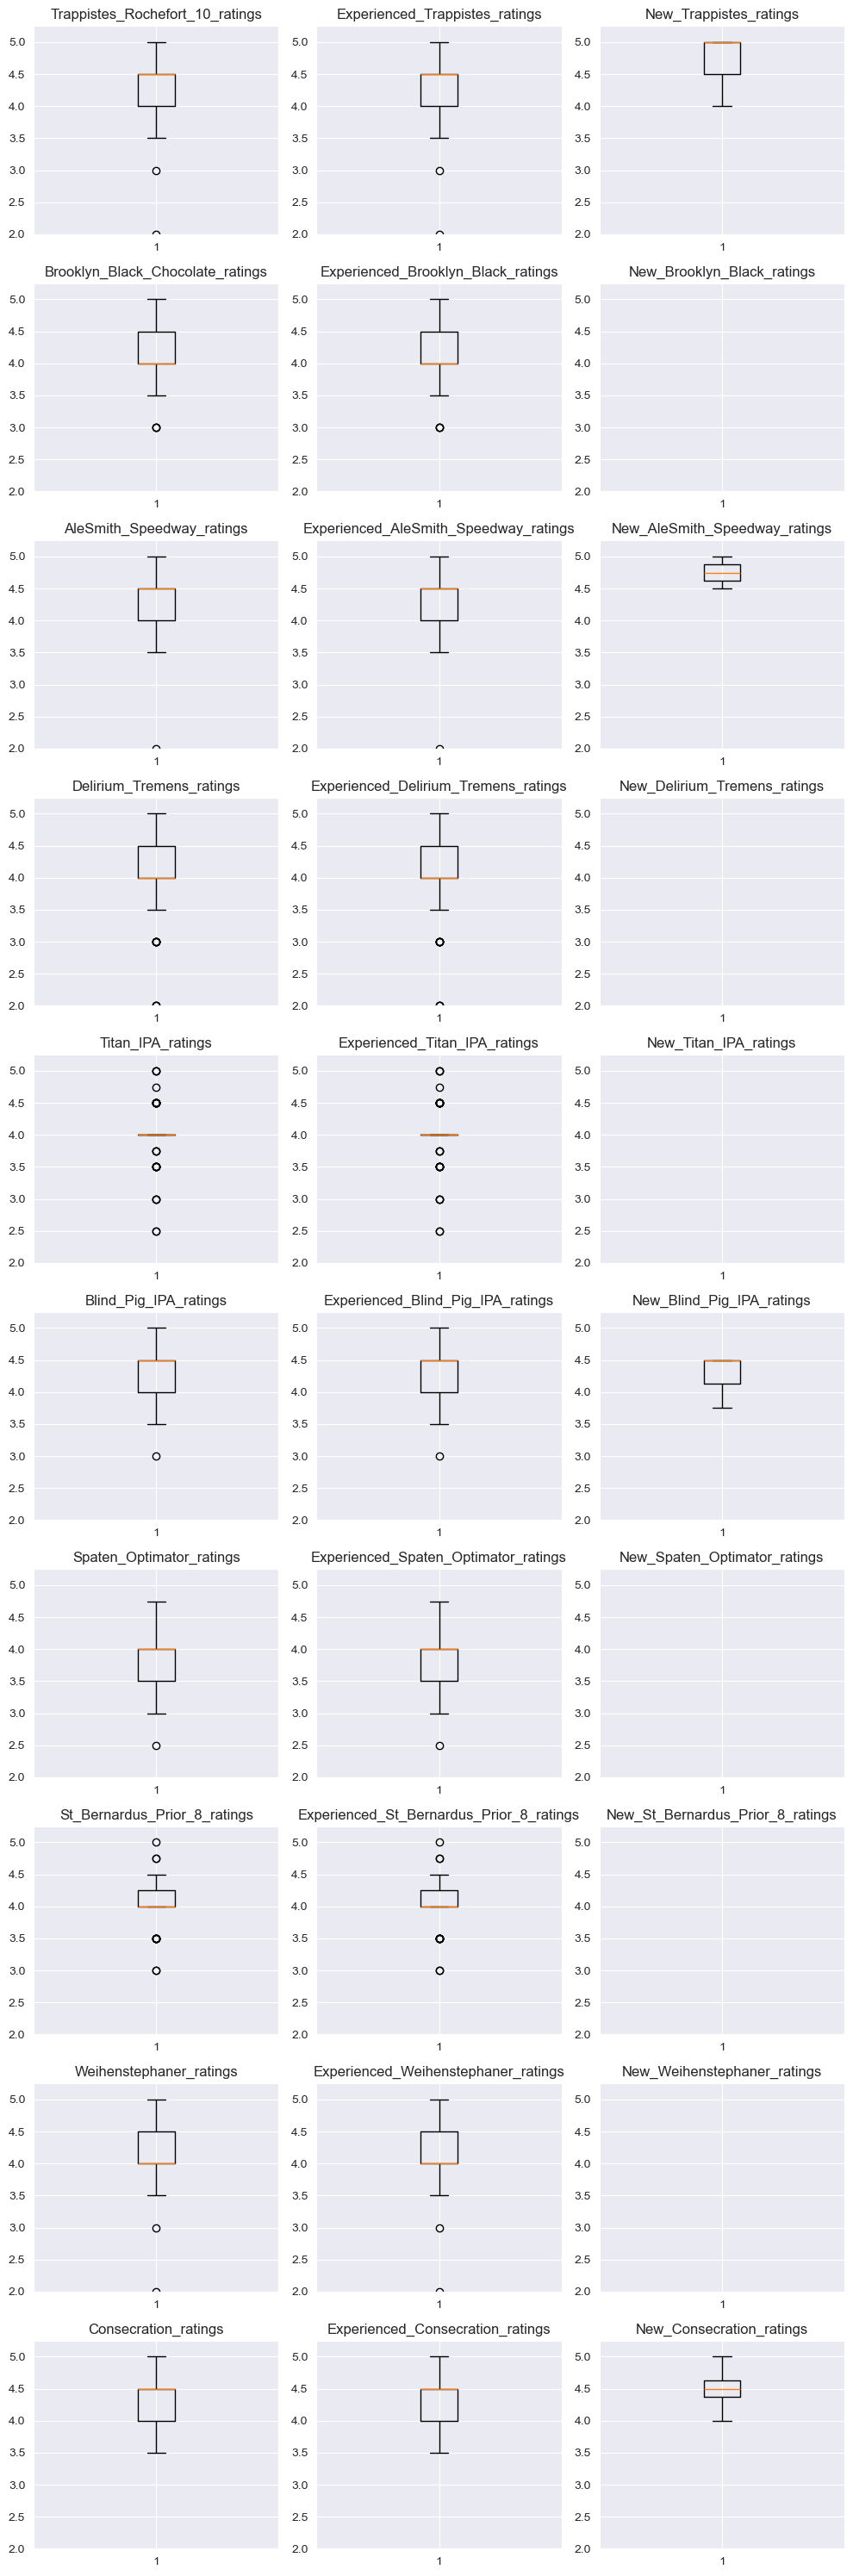

In [10]:
#The following code creates boxplots to show the distribution fo ratings for each beer type for all, experienced and new reviewers.
fig, axes = plt.subplots(10, 3, figsize=(10, 30)) #This allows for the display of the results in subplots

#To be used in the for loops, a list of the names to find the relevant data was needed. The paragraphe below is just the collection of used names to create each boxplot.
Top_10_Beer_types = ['Trappistes_Rochefort_10_ratings', 'Brooklyn_Black_Chocolate_ratings','AleSmith_Speedway_ratings','Delirium_Tremens_ratings','Titan_IPA_ratings','Blind_Pig_IPA_ratings','Spaten_Optimator_ratings','St_Bernardus_Prior_8_ratings','Weihenstephaner_ratings','Consecration_ratings']
Experienced_Top_10_Beer_types = ['Experienced_Trappistes_ratings', 'Experienced_Brooklyn_Black_ratings','Experienced_AleSmith_Speedway_ratings','Experienced_Delirium_Tremens_ratings','Experienced_Titan_IPA_ratings','Experienced_Blind_Pig_IPA_ratings','Experienced_Spaten_Optimator_ratings','Experienced_St_Bernardus_Prior_8_ratings','Experienced_Weihenstephaner_ratings','Experienced_Consecration_ratings']
New_Top_10_Beer_types = ['New_Trappistes_ratings', 'New_Brooklyn_Black_ratings','New_AleSmith_Speedway_ratings','New_Delirium_Tremens_ratings','New_Titan_IPA_ratings','New_Blind_Pig_IPA_ratings','New_Spaten_Optimator_ratings','New_St_Bernardus_Prior_8_ratings','New_Weihenstephaner_ratings','New_Consecration_ratings']
selecting_data_with_iloc = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
boxplot_placement = -1

#Plotting for all reviewers
for BeerType in Top_10_Beer_types:
    boxplot_placement += 1
    data_top10_beer = eval(BeerType)
    axes[boxplot_placement,0].boxplot(data_top10_beer['ratings'])
    axes[boxplot_placement,0].set_ylim(2,5.25)
    axes[boxplot_placement,0].set_title(f'{BeerType}')
#Plotting for Experienced reviewers
boxplot_placement = -1
for BeerType in Experienced_Top_10_Beer_types:
    boxplot_placement += 1
    data_top10_experiencedbeer = eval(BeerType)
    axes[boxplot_placement,1].boxplot(data_top10_experiencedbeer['ratings'])
    axes[boxplot_placement,1].set_ylim(2,5.25)
    axes[boxplot_placement,1].set_title(f'{BeerType}')
#Plotting for New reviewers
boxplot_placement = -1
for BeerType in New_Top_10_Beer_types:
    boxplot_placement += 1
    data_top10_newbeer = eval(BeerType)
    axes[boxplot_placement,2].boxplot(data_top10_newbeer['ratings'])
    axes[boxplot_placement,2].set_ylim(2,5.25)
    axes[boxplot_placement,2].set_title(f'{BeerType}')
    
#Information to properly display plots
plt.tight_layout() #Helps spacing plots
plt.show()

In [11]:
#The threshold of 15 reviews to be considered as experienced filters the majority of reviewers and in some cases amongst the top 10 most rated beers there are no new reviewers. The data is therefore dominated by the >= reviewers. Changing the threshold to 150 could provide a greater distinction between reviewers.